# Lightgbm-demo

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error # accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [4]:
data_dir = Path('C:\DACON\dataset')
sub_dir = Path('C:\DACON\/build')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'submission.csv'

target_col = 'count'
seed = 12

In [5]:
algo_name = 'lgb'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

# feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'
print(sub_file)

C:\DACON\build\lgb_feature.csv


In [6]:
trn = pd.read_csv(trn_file, index_col=0)
tst = pd.read_csv(tst_file, index_col=0)

# 앞의 값으로 결측치 채우기
trn = trn.fillna(method='ffill')
tst = tst.fillna(method='ffill')

print(trn.shape, tst.shape)
trn.head()

(1459, 10) (715, 9)


,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
id,,,,,,,,,,
3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [8]:
y = trn[target_col]
trn.drop(target_col, axis=1, inplace=True)
feature_name = trn.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(1459,) (1459, 9) (715, 9)


## 학습/검증 데이터 구분

In [9]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(1167, 9) (292, 9) (1167,) (292,)


## LightGBM 모델 학습

In [12]:
clf = lgb.LGBMRegressor(n_estimators=1000,
                         num_leaves=64,
                         learning_rate=0.1,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         n_jobs=-1)
clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        early_stopping_rounds=10)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

[1]	valid_0's rmse: 74.4371	valid_0's l2: 5540.88
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 69.2978	valid_0's l2: 4802.19
[3]	valid_0's rmse: 64.9505	valid_0's l2: 4218.57
[4]	valid_0's rmse: 60.7455	valid_0's l2: 3690.01
[5]	valid_0's rmse: 58.2548	valid_0's l2: 3393.62
[6]	valid_0's rmse: 55.1732	valid_0's l2: 3044.08
[7]	valid_0's rmse: 53.5576	valid_0's l2: 2868.42
[8]	valid_0's rmse: 50.913	valid_0's l2: 2592.14
[9]	valid_0's rmse: 48.7334	valid_0's l2: 2374.95
[10]	valid_0's rmse: 47.1247	valid_0's l2: 2220.74
[11]	valid_0's rmse: 45.8004	valid_0's l2: 2097.67
[12]	valid_0's rmse: 44.9162	valid_0's l2: 2017.47
[13]	valid_0's rmse: 44.1923	valid_0's l2: 1952.96
[14]	valid_0's rmse: 43.0943	valid_0's l2: 1857.11
[15]	valid_0's rmse: 42.1529	valid_0's l2: 1776.87
[16]	valid_0's rmse: 41.5708	valid_0's l2: 1728.13
[17]	valid_0's rmse: 40.9296	valid_0's l2: 1675.23
[18]	valid_0's rmse: 40.3142	valid_0's l2: 1625.23
[19]	valid_0's rmse: 39.9654	va

In [15]:
print('r2:', f'{r2_score(y_val, p_val):.4f}')
print('mse:', f'{mean_squared_error(y_val, p_val):.4f}')

r2: 0.7820
mse: 1373.0157


## 피처 중요도 시각화

<AxesSubplot:ylabel='feature'>

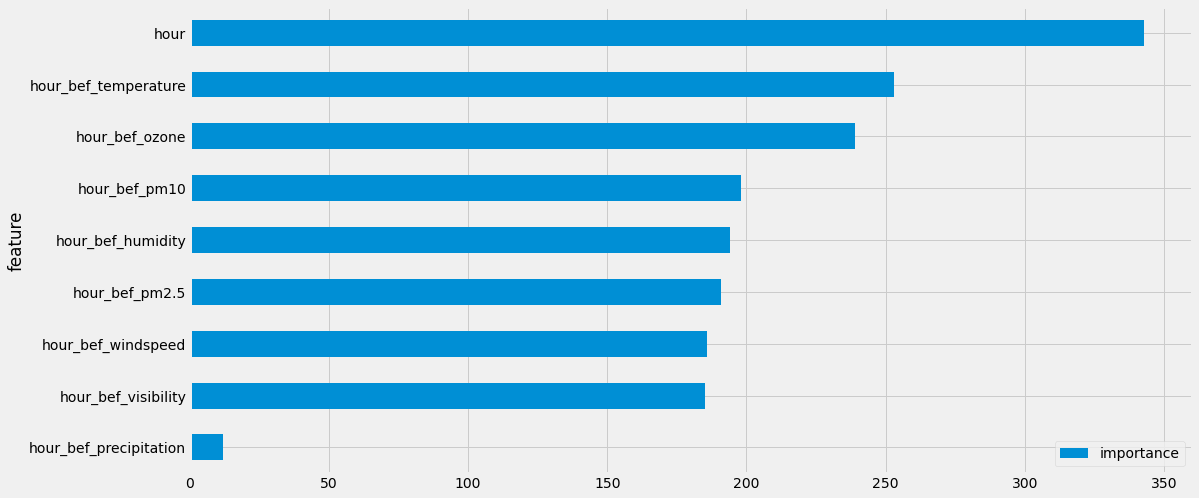

In [16]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [17]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(715, 1)


,count
id,
0,NaN
1,NaN
2,NaN
4,NaN
5,NaN


In [18]:
sub[target_col] = p_tst.round().astype(int) # count는 int형
sub.head()

,count
id,
0,112
1,209
2,69
4,42
5,39


In [19]:
sub[target_col].value_counts()

36     12
33      9
32      8
103     8
45      8
       ..
143     1
172     1
333     1
67      1
151     1
Name: count, Length: 259, dtype: int64

In [20]:
sub.to_csv(sub_file)